[View in Colaboratory](https://colab.research.google.com/github/buddharajuramaraju/ImageClassification-DL-Project/blob/master/ImageClassification.ipynb)

**Image Classification Project**
In this project, you'll classify images from the CIFAR-10 dataset

## **Step:1** Downloading data from source

In [57]:
from urllib.request import urlretrieve
from os.path import isfile,isdir
from tqdm import tqdm
import tarfile

    
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import random


In [58]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

In [59]:
class DLProgress(tqdm):
  last_block = 0
  
  def hook(self,block_num=1,block_size=1,total_size=None):
    self.total = total_size
    self.update((block_num-self.last_block)*block_size)
    self.last_block=block_num

In [60]:
if not isfile('cifar-10-python.tar.gz'):
  with DLProgress(unit='B',unit_scale=True,miniters=1,desc='CIFAR-10 Dataset') as pbar:
    urlretrieve('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz','cifar-10-python.tar.gz',pbar.hook)
                
if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()
  

## **Step:2 Data Visualization**

In [61]:
#function to unpickle images & label_names
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [62]:
#get label names from batches.meta file
label_names = unpickle("{}/batches.meta".format(cifar10_dataset_folder_path))
label_name_array=label_names[b'label_names']


In [63]:
#get images and label index from batch files
batch_num = 5 ## values 1 to 5 only
data_label = unpickle("{}/data_batch_{}".format(cifar10_dataset_folder_path,batch_num))

data = data_label[b'data']
imgs=np.asanyarray(data).astype("uint8")




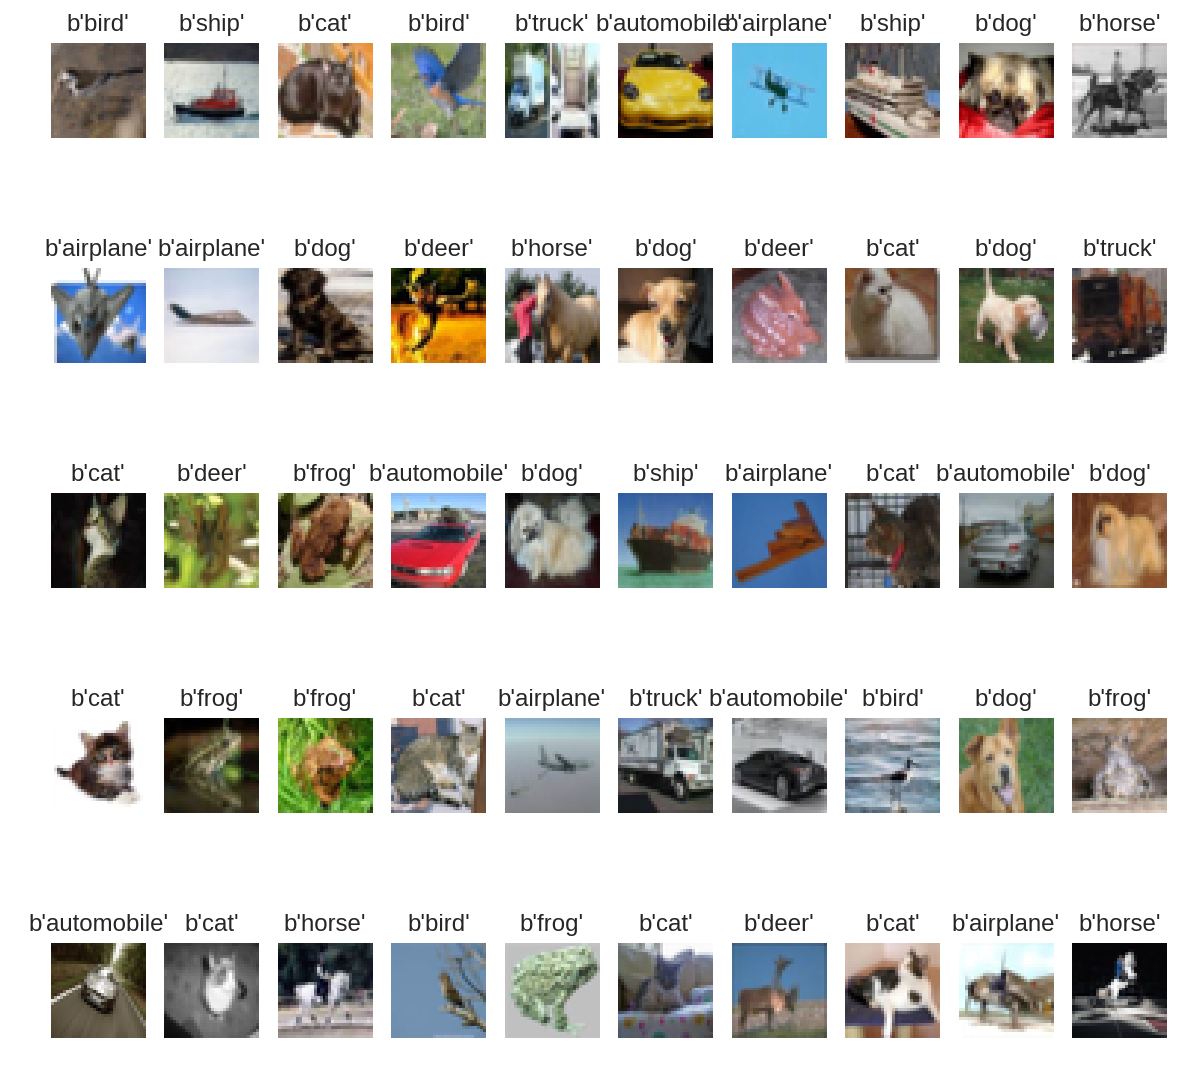

In [64]:
columns = 10
rows = 5
fig=plt.figure(figsize=(10, 10))

for i in range(1, columns*rows +1):
    num = random.randint(0,10000)
    one_img=imgs[num,:]
    img=one_img.reshape(3,32,32).transpose([1, 2, 0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    fig.gca().grid(False)
    plt.title(label_name_array[int(data_label[b'labels'][num])])

## Step:3 Data Preprocessing & Saving

In [65]:
## Function to normalize image data
## This is to convert RGB image to gray scale image of range 0 to 1
def normalize(x):
  return x/255  ## min value is 0 & max value is 255 for RGB


In [66]:
## Function for one-hot encoding 
def one_hot_encoding(x):
  return np.asarray(pd.get_dummies(x))

In [67]:
## Function to load batch from data set
def load_cifar10_batch(cifar10_dataset_folder_path,batch_num):
  data_label = unpickle("{}/data_batch_{}".format(cifar10_dataset_folder_path,batch_num))
  #print(data_label)
  features = data_label[b'data'].reshape(len(data_label[b'data']),3,32,32).transpose(0,2,3,1)
  labels = data_label[b'labels']
  return features,labels

## Function to load test data from data set
def load_cifar10_test(cifar10_dataset_folder_path):
  data_label = unpickle("{}/test_batch".format(cifar10_dataset_folder_path))
  features = data_label[b'data'].reshape(len(data_label[b'data']),3,32,32).transpose(0,2,3,1)
  labels = data_label[b'labels']
  return features,labels

In [68]:
## Function to normalize features and perform one_hot_encoding on labels
def _preprocess_and_save(normalize,one_hot_encoding,features,labels,filename):
  features = normalize(features)
  labels = one_hot_encoding(labels)
  pickle.dump((features,labels),open(filename,'wb'))

In [69]:
## Function to preprocess,split and save Traing, Validation & Test Data
def preprocess_and_save(cifar10_dataset_folder_path,normalize,one_hot_encoding):
  
  num_batches = 5
  valid_features = []
  valid_labels = []
  
  for i in range (1,num_batches+1):
    
    # Load Data from batches
    features,labels = load_cifar10_batch(cifar10_dataset_folder_path,i)
    valid_count = int(len(features)*0.1)
    
    #print(features[:-valid_count])
    #To Save Traing Data
    _preprocess_and_save(normalize,one_hot_encoding,features[:-valid_count],labels[:-valid_count],"preprocess_batch_{}.p".format(i)) 
    
    # Validation Data from batch
    valid_features.extend(features[-valid_count:])
    valid_labels.extend(labels[-valid_count:])
  
  # To Save Validation Data
  _preprocess_and_save(normalize,one_hot_encoding,np.asarray(valid_features),np.asarray(valid_labels),"preprocess_validation.p".format(i))
  
  
  # To Save Test Data 
  
  features_test,labels_test = load_cifar10_test(cifar10_dataset_folder_path)
  _preprocess_and_save(normalize,one_hot_encoding,features_test,labels_test,"preprocess_test.p".format(i))
  

  

In [70]:
## Preprocess and save Train, Validation & Test Data
preprocess_and_save(cifar10_dataset_folder_path,normalize,one_hot_encoding)

In [71]:
!ls

checkpoint				  preprocess_batch_1.p
cifar-10-batches-py			  preprocess_batch_2.p
cifar-10-python.tar.gz			  preprocess_batch_3.p
datalab					  preprocess_batch_4.p
image_classification.data-00000-of-00001  preprocess_batch_5.p
image_classification.index		  preprocess_test.p
image_classification.meta		  preprocess_validation.p


## Step:4 Implementing Input Methods

In [72]:
## Function to return batch of Image Input
def neural_net_image_input(image_shape):
  return tf.placeholder(tf.float32,shape=(None,)+image_shape,name='x')

In [73]:
## Function to return batch of Label Input
def neural_net_label_input(n_classes):
  return tf.placeholder(tf.float32,shape=(None,n_classes),name='y')

In [74]:
## Function to return keep probability for drop outs
def neural_net_keep_prob_input():
  return tf.placeholder(tf.float32,name='keep_prob')

## Step:5 Implementing Convolution and Max Pooling Layer

In [367]:
## This is to build Convolution and Max Pooling Layer
#x_tensor: input
#conv_num_outputs: Number of output from convolution layer
#conv_ksize : convolutional layer kernal size
#conv_strides : convolutionallayer Sride
#pool_ksize: max-pooling kernal size
#pool_strides: max-pooling srides 
#


def conv2d_maxpool(x_tensor,conv_num_outputs,conv_ksize,conv_strides,pool_ksize,pool_strides):
  
  ## To Caluculate weights and bias
  weights = tf.Variable(tf.truncated_normal([*conv_ksize,x_tensor.shape.as_list()[3],conv_num_outputs],stddev=5e-2))
  bias = tf.Variable(tf.zeros(conv_num_outputs))
  
  ## Convolution layer
  
  conv_layer = tf.nn.conv2d(x_tensor,weights,strides=[1,*conv_strides,1],padding='SAME')
  
  ## Add bias
  
  conv_layer = tf.nn.bias_add(conv_layer,bias)
  
  
  ## Add activation function
  
  conv_layer = tf.nn.relu(conv_layer)
  
  
  ## Add max-pooling 
  
  conv_layer = tf.nn.max_pool(conv_layer,ksize=[1,*pool_ksize,1],strides=[1,*pool_strides,1],padding='SAME')
  
  return conv_layer
  
  
  
  
  
  
  
  

## Step:6 Implementing Flatten Layer 

In [368]:
def flatten(x_tensor):
  return tf.contrib.layers.flatten(x_tensor) ## Using tensorflow flatten function

## Step:7 Implementing Fully Connected Layer

In [369]:
def fully_conn(x_tensor,num_outputs):
  return tf.layers.dense(x_tensor,num_outputs)

## Step:8 Implementing Output Layer

In [370]:
def output(x_tensor,num_outputs):
  return tf.layers.dense(x_tensor,num_outputs)

## Step:9 Implementing Convolution Network

In [455]:
def conv_net(x,keep_prob):
  
  # Apply 3 convolutional layers
  
  
  ## Convolution Layer-1
  x = conv2d_maxpool(x,64,(5,5),(1,1),(3,3),(2,2))
  x = tf.layers.dropout(x,rate=keep_prob)
  
  ## Convolution Layer-2
  x = conv2d_maxpool(x,64,(5,5),(1,1),(3,3),(2,2))
  x = tf.layers.dropout(x,rate=keep_prob)
  
  ## Convolution Layer-3
  #x = conv2d_maxpool(x,64,(5,5),(1,1),(3,3),(2,2))
  #x = tf.layers.dropout(x,rate=keep_prob)
  
  
  # Apply Flatten Layer
  x = flatten(x)
  
  
  
  # Apply 3 Fully Connected Layers
  
  #x = fully_conn(x,768)
  x = fully_conn(x,384)
  x = fully_conn(x,192)
  #x = fully_conn(x,86)
  #x = fully_conn(x,43)
  
  
  # Apply output Layer
  
  x = output(x,10)
  
  return x
  

## Step 10: Implement Tensorflow Neural Network

In [456]:
tf.reset_default_graph()

In [457]:
#Inputs
x = neural_net_image_input((32,32,3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

In [458]:
logits = conv_net(x,keep_prob)

In [459]:
logits = tf.identity(logits,name="logits")

In [460]:
## Loss and Optimizer 
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)
#optimizer = tf.train.GradientDescentOptimizer(0.00001).minimize(cost)

In [461]:
## Accuracy
correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

## Step:11 Train Network

In [462]:
def train_network(session,optimizer,keep_probability,feature_batch,label_batch):
  session.run(optimizer,feed_dict={x:feature_batch,y:label_batch,keep_prob:keep_probability})
  

In [463]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [464]:
def print_status(session,feature_batch,label_batch,cost,accuracy):
  
  #Calculate Loss
  loss = session.run(cost,feed_dict={x:feature_batch,y:label_batch,keep_prob:1.0})
  #Calculate accuracy
  valid_acc = session.run(accuracy,feed_dict={x:valid_features,y:valid_labels,keep_prob:1.0})
  # Print
  print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss,valid_acc))
  

**Hyperparameters**

In [465]:
epochs = 100
batch_size = 256
keep_probability = 0.75

In [466]:
## Function to split and return data into batches
def batch_features_labels(features, labels, batch_size):
     for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

In [467]:
## Function to load preprocess_training_batch
def load_preprocess_train_batch(batch_id,batch_size):
  filename = "preprocess_batch_{}.p".format(batch_id)
  #print(filename)
  features,labels = pickle.load(open(filename,'rb'))
  #print(features)
  return batch_features_labels(features, labels, batch_size)

### Test train model on Single Batch

In [469]:
## Test run on Batch-1 
print("Testing batch-1")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        #print(epoch)
        batch_i = 1
        #print("-->",load_preprocess_train_batch(batch_i, batch_size).size())
        for batch_features, batch_labels in load_preprocess_train_batch(batch_i, batch_size):
            #print(batch_labels)
            train_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_status(sess, batch_features, batch_labels, cost, accuracy)

Testing batch-1
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.1754 Validation Accuracy: 0.283800
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.9357 Validation Accuracy: 0.374400
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.6517 Validation Accuracy: 0.399800


KeyboardInterrupt: ignored

### Fully train the model & saving

In [296]:
print("Training....")
save_model_path = './image_classification'

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        n_batchs = 5
        for batch_i in range(1,n_batchs+1):
                for batch_features, batch_labels in load_preprocess_train_batch(batch_i, batch_size):            
                  train_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
                print_status(sess, batch_features, batch_labels, cost, accuracy)
                  
     #Save Model 
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training....
Epoch  1, CIFAR-10 Batch 1:  Loss:   576.2367 Validation Accuracy: 0.178800
Epoch  1, CIFAR-10 Batch 2:  Loss:    76.3124 Validation Accuracy: 0.304200
Epoch  1, CIFAR-10 Batch 3:  Loss:    21.2278 Validation Accuracy: 0.390400
Epoch  1, CIFAR-10 Batch 4:  Loss:    45.4045 Validation Accuracy: 0.248400
Epoch  1, CIFAR-10 Batch 5:  Loss:    35.6793 Validation Accuracy: 0.328800
Epoch  2, CIFAR-10 Batch 1:  Loss:    16.9178 Validation Accuracy: 0.429800
Epoch  2, CIFAR-10 Batch 2:  Loss:    10.8237 Validation Accuracy: 0.366200
Epoch  2, CIFAR-10 Batch 3:  Loss:     2.1999 Validation Accuracy: 0.436800
Epoch  2, CIFAR-10 Batch 4:  Loss:     4.2773 Validation Accuracy: 0.444600
Epoch  2, CIFAR-10 Batch 5:  Loss:     6.5814 Validation Accuracy: 0.472400
Epoch  3, CIFAR-10 Batch 1:  Loss:     6.9475 Validation Accuracy: 0.407400
Epoch  3, CIFAR-10 Batch 2:  Loss:     0.5021 Validation Accuracy: 0.503800
Epoch  3, CIFAR-10 Batch 3:  Loss:     1.5598 Validation Accuracy: 0.449000

Loss:     0.1981 Validation Accuracy: 0.504600
Epoch  8, CIFAR-10 Batch 2:  Loss:     0.2421 Validation Accuracy: 0.441400
Epoch  8, CIFAR-10 Batch 3:  Loss:     0.3235 Validation Accuracy: 0.491200
Epoch  8, CIFAR-10 Batch 4:  Loss:     0.2429 Validation Accuracy: 0.478000
Epoch  8, CIFAR-10 Batch 5:  Loss:     0.1384 Validation Accuracy: 0.512000
Epoch  9, CIFAR-10 Batch 1:  Loss:     0.2026 Validation Accuracy: 0.485800
Epoch  9, CIFAR-10 Batch 2:  Loss:     0.1499 Validation Accuracy: 0.448600
Epoch  9, CIFAR-10 Batch 3:  Loss:     0.1571 Validation Accuracy: 0.469600
Epoch  9, CIFAR-10 Batch 4:  Loss:     0.1388 Validation Accuracy: 0.495400
Epoch  9, CIFAR-10 Batch 5:  Loss:     0.1742 Validation Accuracy: 0.490400
Epoch 10, CIFAR-10 Batch 1:  Loss:     0.1681 Validation Accuracy: 0.499600
Epoch 10, CIFAR-10 Batch 2:  Loss:     0.1220 Validation Accuracy: 0.466400
Epoch 10, CIFAR-10 Batch 3:  Loss:     0.0403 Validation Accuracy: 0.503800
Epoch 10, CIFAR-10 Batch 4:  Loss:     0.

KeyboardInterrupt: ignored

In [54]:
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt


def _load_label_names():
  
  return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Sample Test Image Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [50]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'




save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
   

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')

        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0

        for test_feature_batch, test_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.47138671875



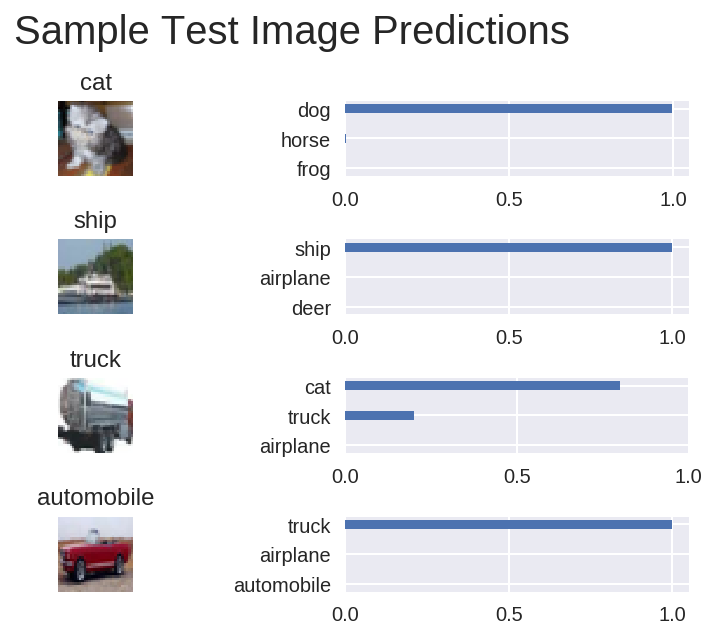

In [55]:
test_model()